In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# plot inside the notebook rather than in a new window
%matplotlib inline

In [2]:
# Data loading and cleaning

In [3]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
df.shape

(891, 12)

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
def sanitise_frame(frame):
    return frame \
    .drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked']) \
    .assign(Sex=lambda x: x['Sex'].map({ 'male': 0, 'female': 1 })) \
    .apply(pd.to_numeric, errors='ignore') \
    .fillna(df.mean())

df = sanitise_frame(df)
df_test = sanitise_frame(df_test)

In [7]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,0,22.0,1,0,7.2500
1,2,1,1,1,38.0,1,0,71.2833
2,3,1,3,1,26.0,0,0,7.9250
3,4,1,1,1,35.0,1,0,53.1000
4,5,0,3,0,35.0,0,0,8.0500


In [8]:
# Correlation fun

Correlation p-value for PassengerId: 0.8813657768798144 
Correlation p-value for Pclass: 2.53704738798042e-25 - Significant
Correlation p-value for Sex: 1.406066130879597e-69 - Significant
Correlation p-value for Age: 0.03721708372683364 - Significant
Correlation p-value for SibSp: 0.29224392869817906 
Correlation p-value for Parch: 0.0147992453747224 - Significant
Correlation p-value for Fare: 6.120189341921873e-15 - Significant


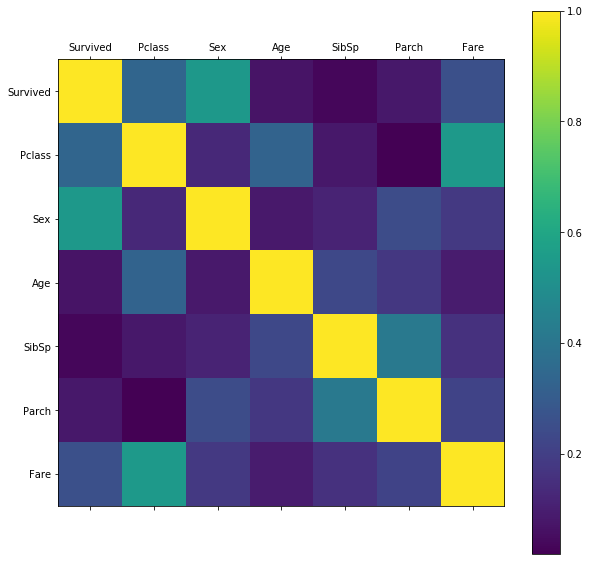

In [9]:
from scipy.stats import pearsonr

def plot_correlation(dataset):
    """
    Plots a correlation graph for a dataset. Look ma I can print 'pretty' graphs.
    """
    _, axis = plt.subplots(
        figsize=(10,10)
    )
    
    corr_tab = dataset.corr().apply(np.abs)
    
    plot = axis.matshow(corr_tab)
    plt.xticks(range(len(corr_tab.columns)), corr_tab.columns)
    plt.yticks(range(len(corr_tab.index)), corr_tab.index)
    plt.colorbar(plot)


plot_correlation(df.drop(columns='PassengerId'))

for column in df.drop(columns='Survived'):
    _, p_val = pearsonr(df['Survived'], df[column])
    print(f'Correlation p-value for {column}: {p_val} {p_val < 0.05 and "- Significant" or ""}')

In [10]:
# Re-split in test/train

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X, X_test, y, y_test = train_test_split(
    df.drop(columns=['Survived', 'SibSp']), 
    df['Survived'], 
    test_size=0.15, 
    random_state=123  # consistency between runs
)

In [13]:
# Multiple linear regression fit. ML is overrated anyway

In [14]:
from sklearn import linear_model

In [15]:
lm = linear_model.LinearRegression().fit(X, y)

df_res = pd.DataFrame(
    data={
        'Predicted': pd.Series(lm.predict(X_test), index=X_test.index),
        'Survived': y_test
    }
)
df_res['rounded_prediction'] = df_res['Predicted'].map(lambda x: 0 if x < 0.5 else 1)
df_res['Success'] = df_res['rounded_prediction'].eq(df_res['Survived'])

df_res.head()

,Predicted,Survived,rounded_prediction,Success
172,0.720770,1,1,True
524,0.103882,0,0,True
452,0.459909,0,0,True
170,0.295520,0,0,True
620,0.120599,0,0,True


In [16]:
lm_score = df_res['Success'].value_counts()[True] / df_res['Success'].count()
print('score for linear regression: ', lm_score)

score for linear regression:  0.835820895522388


In [17]:
# Data export

In [18]:
df_final = pd.DataFrame(
    data={
        'PassengerId': df_test['PassengerId'],
        'Survived': pd.Series(
            lm.predict(df_test.drop(columns='SibSp'))
        ).map(lambda x: 0 if x < 0.5 else 1)
    }
)
df_final.to_csv('titanic_result_linear_regression.csv', index=False)